# <p style="text-align: center;">Multiclass Image Classification Using VGGNet</p>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import os 
import glob
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
os.listdir('/kaggle/input/intel-image-classification/seg_train/seg_train')

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.img_paths = []
        for c in self.classes:
            class_dir = os.path.join(data_dir, c)
            for img_file in os.listdir(class_dir):
                self.img_paths.append((os.path.join(class_dir, img_file), self.class_to_idx[c]))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path, label = self.img_paths[index]
        with open(img_path, 'rb') as f:
            img = Image.open(f).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [14]:
train_dataset=CustomDataset('/kaggle/input/intel-image-classification/seg_train/seg_train/',
                     transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                                              torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])]))

test_dataset=CustomDataset('/kaggle/input/intel-image-classification/seg_test/seg_test/',
                     transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                                              torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])]))

In [15]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)

tensor(2)


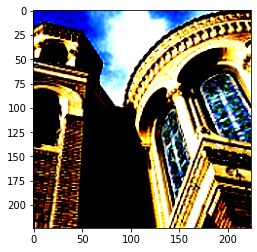

In [16]:
img,label=next(iter(train_loader))
plt.imshow(img[0].permute(1,2,0))
print(label[0])

In [17]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.maxpool1 = nn.Sequential(
            nn.MaxPool2d(kernel_size =2,stride = 2)) 
        
        self.conv2_1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.maxpool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.conv3_1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.conv3_3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.maxpool3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.conv4_1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv4_3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.maxpool4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.conv5_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv5_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.conv5_3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.maxpool5 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.conv1_1(x)
        out = self.conv1_2(out)
        out = self.maxpool1(out)
        out = self.conv2_1(out)
        out = self.conv2_2(out)
        out = self.maxpool2(out)
        out = self.conv3_1(out)
        out = self.conv3_2(out)
        out = self.conv3_3(out)
        out = self.maxpool3(out)
        out = self.conv4_1(out)
        out = self.conv4_2(out)
        out = self.conv4_3(out)
        out = self.maxpool4(out)
        out = self.conv5_1(out)
        out = self.conv5_2(out)
        out = self.conv5_3(out)
        out = self.maxpool5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [18]:
model= VGGNet().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=3e-4)
criterion=nn.CrossEntropyLoss()

In [12]:

for epoch in range(5):
    for img,label in tqdm(train_loader):
        img=img.to(device)
        label=label.to(device)
        
        optimizer.zero_grad()
        output= model(img)
        loss=criterion(output,label)
        
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}] Loss: {loss.item():.4f}")
        

  0%|          | 0/439 [00:00<?, ?it/s]

Epoch [1] Loss: 1.0331


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch [2] Loss: 1.4385


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch [3] Loss: 0.9461


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch [4] Loss: 0.4400


  0%|          | 0/439 [00:00<?, ?it/s]

Epoch [5] Loss: 0.2335
